In [1]:
from import_all import *

In [2]:
file_path1 = '/Users/Julie/Desktop/projet_kyushu/SEMG_DB1/N_TXT/3Nmar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)
    data['Time'] = data.index/1000
    return data

#Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

#Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)



data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])

data["FX"]=abs(data["FX"])

print(data.head())

         RF        BF        VM        ST   FX   Time
0 -0.000358  0.000045 -0.000289  0.000314  4.9  0.000
1 -0.000281 -0.002069  0.002111  0.000540  4.9  0.001
2  0.000585 -0.000215  0.000875  0.002983  4.9  0.002
3 -0.000084 -0.000927  0.002334  0.001633  4.9  0.003
4 -0.000035 -0.001260  0.001879  0.001602  4.9  0.004


In [3]:
# Détection améliorée des cycles de marche
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Seuil ajusté dynamiquement

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Valeur par défaut

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Vérification de la cohérence des cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Valeur par défaut si un seul pic est trouvé

# Détection des débuts de cycles ajustés
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = peaks[i] - shift_amount
    adjusted_peaks.append(adjusted_start)

print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(f'Débuts de cycles ajustés : {adjusted_peaks}')

# Verification du premier cycle
print(len(adjusted_peaks))
for i in range(len(adjusted_peaks)):
    if adjusted_peaks[0] < 0 :
        adjusted_peaks.pop(0)
        print(f'Premier cycle supprimé : {adjusted_peaks}')
    else:
        print(f'Premier cycle valide : {adjusted_peaks}')
        break

cycle_lengths = np.diff(adjusted_peaks)
mean_cycle_length = np.mean(cycle_lengths)

# Calcul du temps moyen des cycles **normaux** (excluant les cycles corrompus)
normal_cycle_times = [t for t in cycle_lengths if t > 1000]
mean_normal_cycle_time = np.mean(normal_cycle_times)



print(f'Temps pour chaque cycle : {cycle_lengths}')
print(f'Temps moyen des cycles normaux : {mean_normal_cycle_time:.2f}')

#Détection et correction des cycles anormaux
new_adjusted_peaks = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_time = (end_time - start_time)*1000


    if cycle_time >= 1.50 * mean_normal_cycle_time:
        num_splits = round(cycle_time / mean_normal_cycle_time)  # Nombre de nouveaux cycles
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, divisé en {num_splits} cycles.')

        # Ajout des nouveaux débuts de cycle répartis uniformément
        for j in range(num_splits):
            new_peak = adjusted_peaks[i] + int(j * mean_normal_cycle_time / (data['Time'][1]*1000 - data['Time'][0]*1000))
            new_adjusted_peaks.append(new_peak)
    elif cycle_time <= 0.50 * mean_normal_cycle_time:
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, supprimé.')
    else:
        new_adjusted_peaks.append(adjusted_peaks[i])

# Ajout du dernier pic s'il n'a pas été traité
if adjusted_peaks:
    new_adjusted_peaks.append(adjusted_peaks[-1])

adjusted_peaks = new_adjusted_peaks

# Affichage des nouveaux débuts de cycles
print(f'Nouveaux débuts de cycles ajustés : {adjusted_peaks}')

# Début d'un nouveau cycle même si il n'y a pas de peak
if adjusted_peaks[-1]+int(np.mean(np.diff(adjusted_peaks))) < len(data):
    adjusted_peaks.append(adjusted_peaks[-1] + int(np.mean(np.diff(adjusted_peaks))))
    print(f'Ajout d\'un début de nouveau cycle : {adjusted_peaks}')
else:
    print(f'Aucun nouveau cycle ajouté : {adjusted_peaks}')

# Suppression des 3 premiers et 3 derniers cycles si le nombre total de cycles est supérieur à 20
if len(adjusted_peaks) > 20:
    adjusted_peaks = adjusted_peaks[3:-3]
    print(f'Suppression des 3 premiers et 3 derniers cycles : {adjusted_peaks}')

Nombre de débuts de cycles ajustés : 5
Débuts de cycles ajustés : [-353, 1056, 2426, 3946, 5213]
5
Premier cycle supprimé : [1056, 2426, 3946, 5213]
Premier cycle valide : [1056, 2426, 3946, 5213]
Temps pour chaque cycle : [1370 1520 1267]
Temps moyen des cycles normaux : 1385.67
Nouveaux débuts de cycles ajustés : [1056, 2426, 3946, 5213]
Ajout d'un début de nouveau cycle : [1056, 2426, 3946, 5213, 6598]


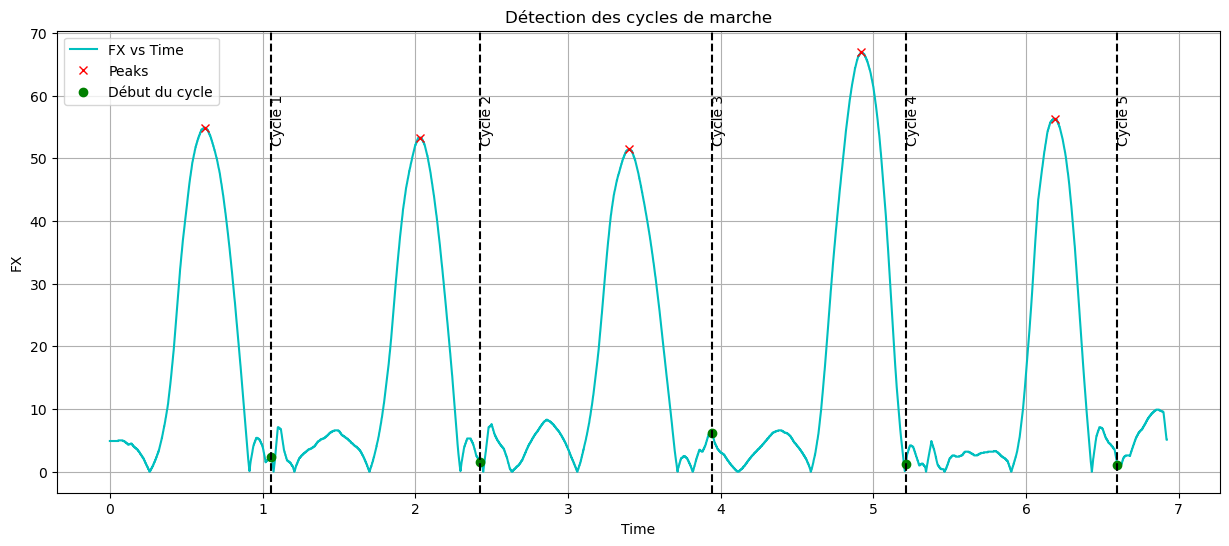

In [4]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# On calcul le temps de chaque cycle et on divise par la fréquence d'échantillonnage pour obtenir le temps en secondes
cycle_durations = np.diff(adjusted_peaks) / 1000 

# Calcul du temps de cycle moyen
average_cycle_time = np.mean(cycle_durations)

print(f"Durée de chaque cycles (en secondes): {cycle_durations}")
print(f"Temps moyen de cycle (en secondes): {average_cycle_time}")

Durée de chaque cycles (en secondes): [1.37  1.52  1.267 1.385]
Temps moyen de cycle (en secondes): 1.3855


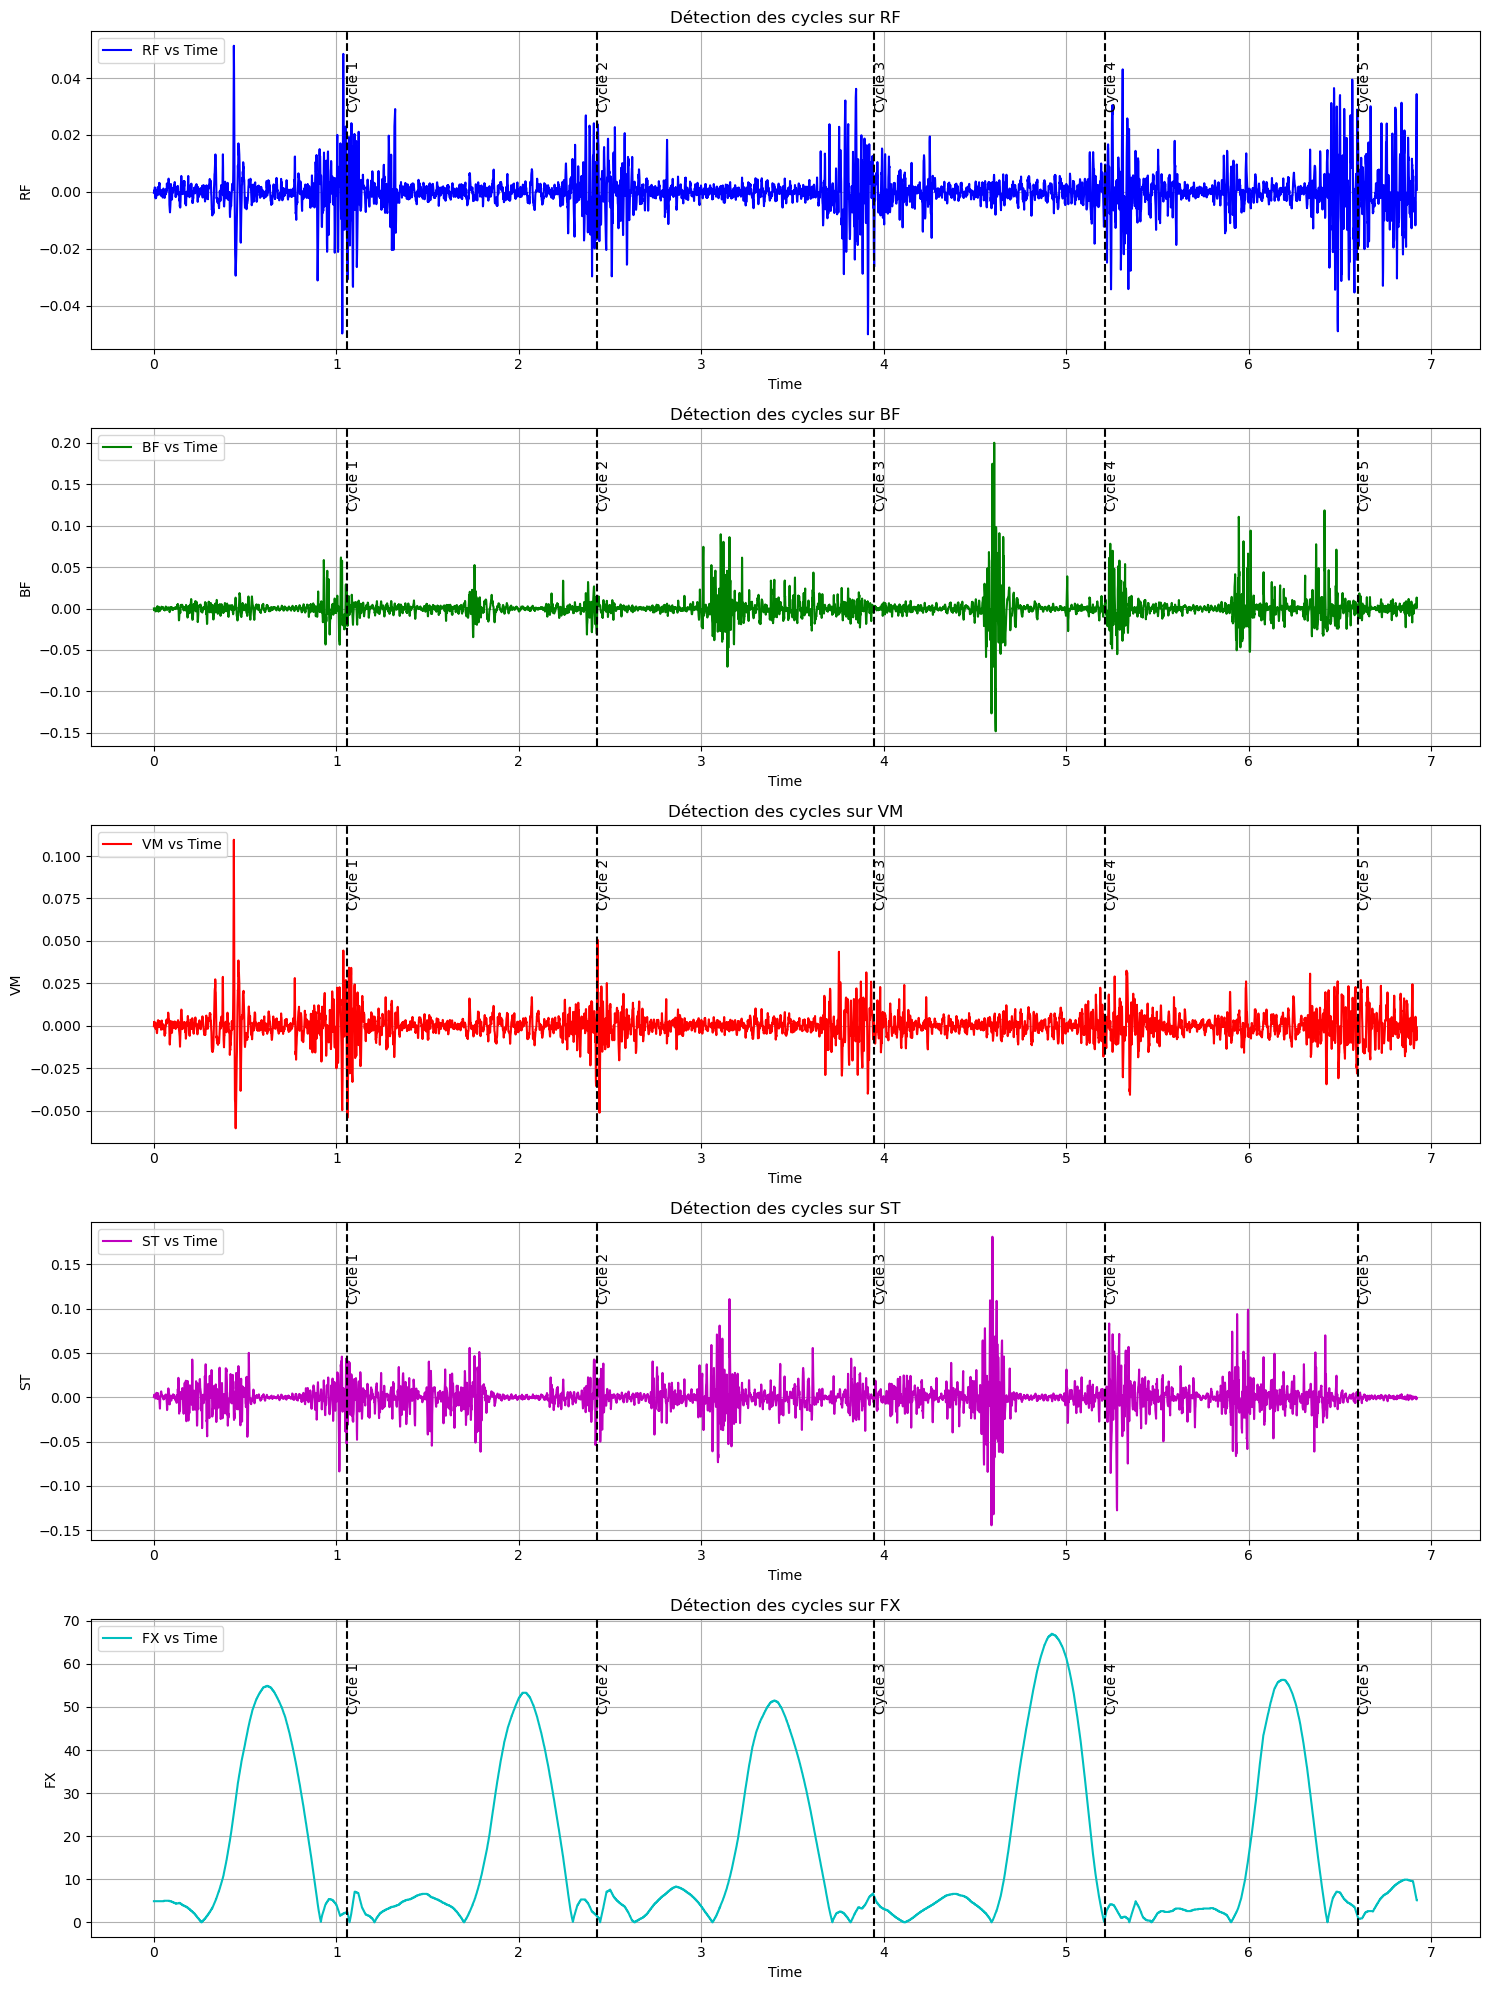

In [6]:
# Liste des colonnes à afficher
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']

# Création des graphiques pour chaque signal avec les cycles marqués
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Détection des cycles sur {col}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Convert float values in adjusted_peaks to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# RMS (Root Mean Square) pour chaque cycle
rms_values_RF = []
rms_values_BF = []
rms_values_VM = []
rms_values_ST = []
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    rms_RF = np.sqrt(np.mean(data['RF'][start:end] ** 2))
    rms_values_RF.append(rms_RF)
    rms_BF = np.sqrt(np.mean(data['BF'][start:end] ** 2))
    rms_values_BF.append(rms_BF)
    rms_VM = np.sqrt(np.mean(data['VM'][start:end] ** 2))
    rms_values_VM.append(rms_VM)
    rms_ST = np.sqrt(np.mean(data['ST'][start:end] ** 2))
    rms_values_ST.append(rms_ST)


print(rms_values_RF)
print(rms_values_BF)
print(rms_values_VM)
print(rms_values_ST)

mean_rms_RF = np.mean(rms_values_RF)
mean_rms_BF = np.mean(rms_values_BF)
mean_rms_VM = np.mean(rms_values_VM)
mean_rms_ST = np.mean(rms_values_ST)

print(f'Mean RMS RF: {mean_rms_RF:.4f}')
print(f'Mean RMS BF: {mean_rms_BF:.4f}')
print(f'Mean RMS VM: {mean_rms_VM:.4f}')
print(f'Mean RMS ST: {mean_rms_ST:.4f}')

[0.005933990336132483, 0.006601226105848847, 0.00400448644245243, 0.008748043847114514]
[0.006414974106172472, 0.011168717635607256, 0.018710296450101027, 0.015697609060967725]
[0.007305397112809899, 0.007764945543603162, 0.005114368838775088, 0.008274613686218709]
[0.012585104274035818, 0.014055802112174085, 0.02025328658448611, 0.018714088007587875]
Mean RMS RF: 0.0063
Mean RMS BF: 0.0130
Mean RMS VM: 0.0071
Mean RMS ST: 0.0164


In [8]:
#Energie pour chaque cycle

energie_values_RF = []
energie_values_BF = []
energie_values_VM = []
energie_values_ST = []

for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    energie_RF = np.sum(np.square(data['RF'][start:end]))
    energie_values_RF.append(energie_RF)
    energie_BF = np.sum(np.square(data['BF'][start:end]))
    energie_values_BF.append(energie_BF)
    energie_VM = np.sum(np.square(data['VM'][start:end]))
    energie_values_VM.append(energie_VM)
    energie_ST = np.sum(np.square(data['ST'][start:end]))
    energie_values_ST.append(energie_ST)

print(energie_values_RF)
print(energie_values_BF)
print(energie_values_VM)
print(energie_values_ST)

mean_energie_RF = np.mean(energie_values_RF)
mean_energie_BF = np.mean(energie_values_BF)
mean_energie_VM = np.mean(energie_values_VM)
mean_energie_ST = np.mean(energie_values_ST)

print(f'Mean Energie RF: {mean_energie_RF:.4f}')
print(f'Mean Energie BF: {mean_energie_BF:.4f}')
print(f'Mean Energie VM: {mean_energie_VM:.4f}')
print(f'Mean Energie ST: {mean_energie_ST:.4f}')


[0.048240770593759766, 0.0662358028728213, 0.020317500083084, 0.1059916555441878]
[0.05637809311252273, 0.1896051855083653, 0.44354526984859016, 0.34128467836990173]
[0.07311529295691616, 0.09164745652858636, 0.03314062584031562, 0.09482988584377879]
[0.2169872439360458, 0.30029967098522814, 0.5197178473387029, 0.4850506695887059]
Mean Energie RF: 0.0602
Mean Energie BF: 0.2577
Mean Energie VM: 0.0732
Mean Energie ST: 0.3805


In [9]:
def calculate_variance(signal):
    N = len(signal)
    mean = np.mean(signal)
    variance = np.sum((signal - mean) ** 2) / (N - 1)
    return variance

# Calcul de la variance pour chaque muscle
var_RF = calculate_variance(data['RF'])
var_BF = calculate_variance(data['BF'])
var_VM = calculate_variance(data['VM'])
var_ST = calculate_variance(data['ST'])

# Affichage des résultats
print("Variance temporelle pour RF :", var_RF)
print("Variance temporelle pour BF :", var_BF)
print("Variance temporelle pour VM :", var_VM)
print("Variance temporelle pour ST :", var_ST)

Variance temporelle pour RF : 4.86373450552761e-05
Variance temporelle pour BF : 0.0001618901241334271
Variance temporelle pour VM : 6.615011304321016e-05
Variance temporelle pour ST : 0.00024326240125552824


In [10]:
def calcul_zcr(signal):
    N = len(signal)
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zcr = len(zero_crossings) / N
    return zcr

# Calcul du ZCR pour chaque muscle
zcr_RF = calcul_zcr(data['RF'])
zcr_BF = calcul_zcr(data['BF'])
zcr_VM = calcul_zcr(data['VM'])
zcr_ST = calcul_zcr(data['ST'])

# Affichage des résultats
print("Zero Crossing Rate pour RF :", zcr_RF)
print("Zero Crossing Rate pour BF :", zcr_BF)
print("Zero Crossing Rate pour VM :", zcr_VM)
print("Zero Crossing Rate pour ST :", zcr_ST)


Zero Crossing Rate pour RF : 0.18852932678416642
Zero Crossing Rate pour BF : 0.19676394105749784
Zero Crossing Rate pour VM : 0.16989309448136378
Zero Crossing Rate pour ST : 0.18419531927188673


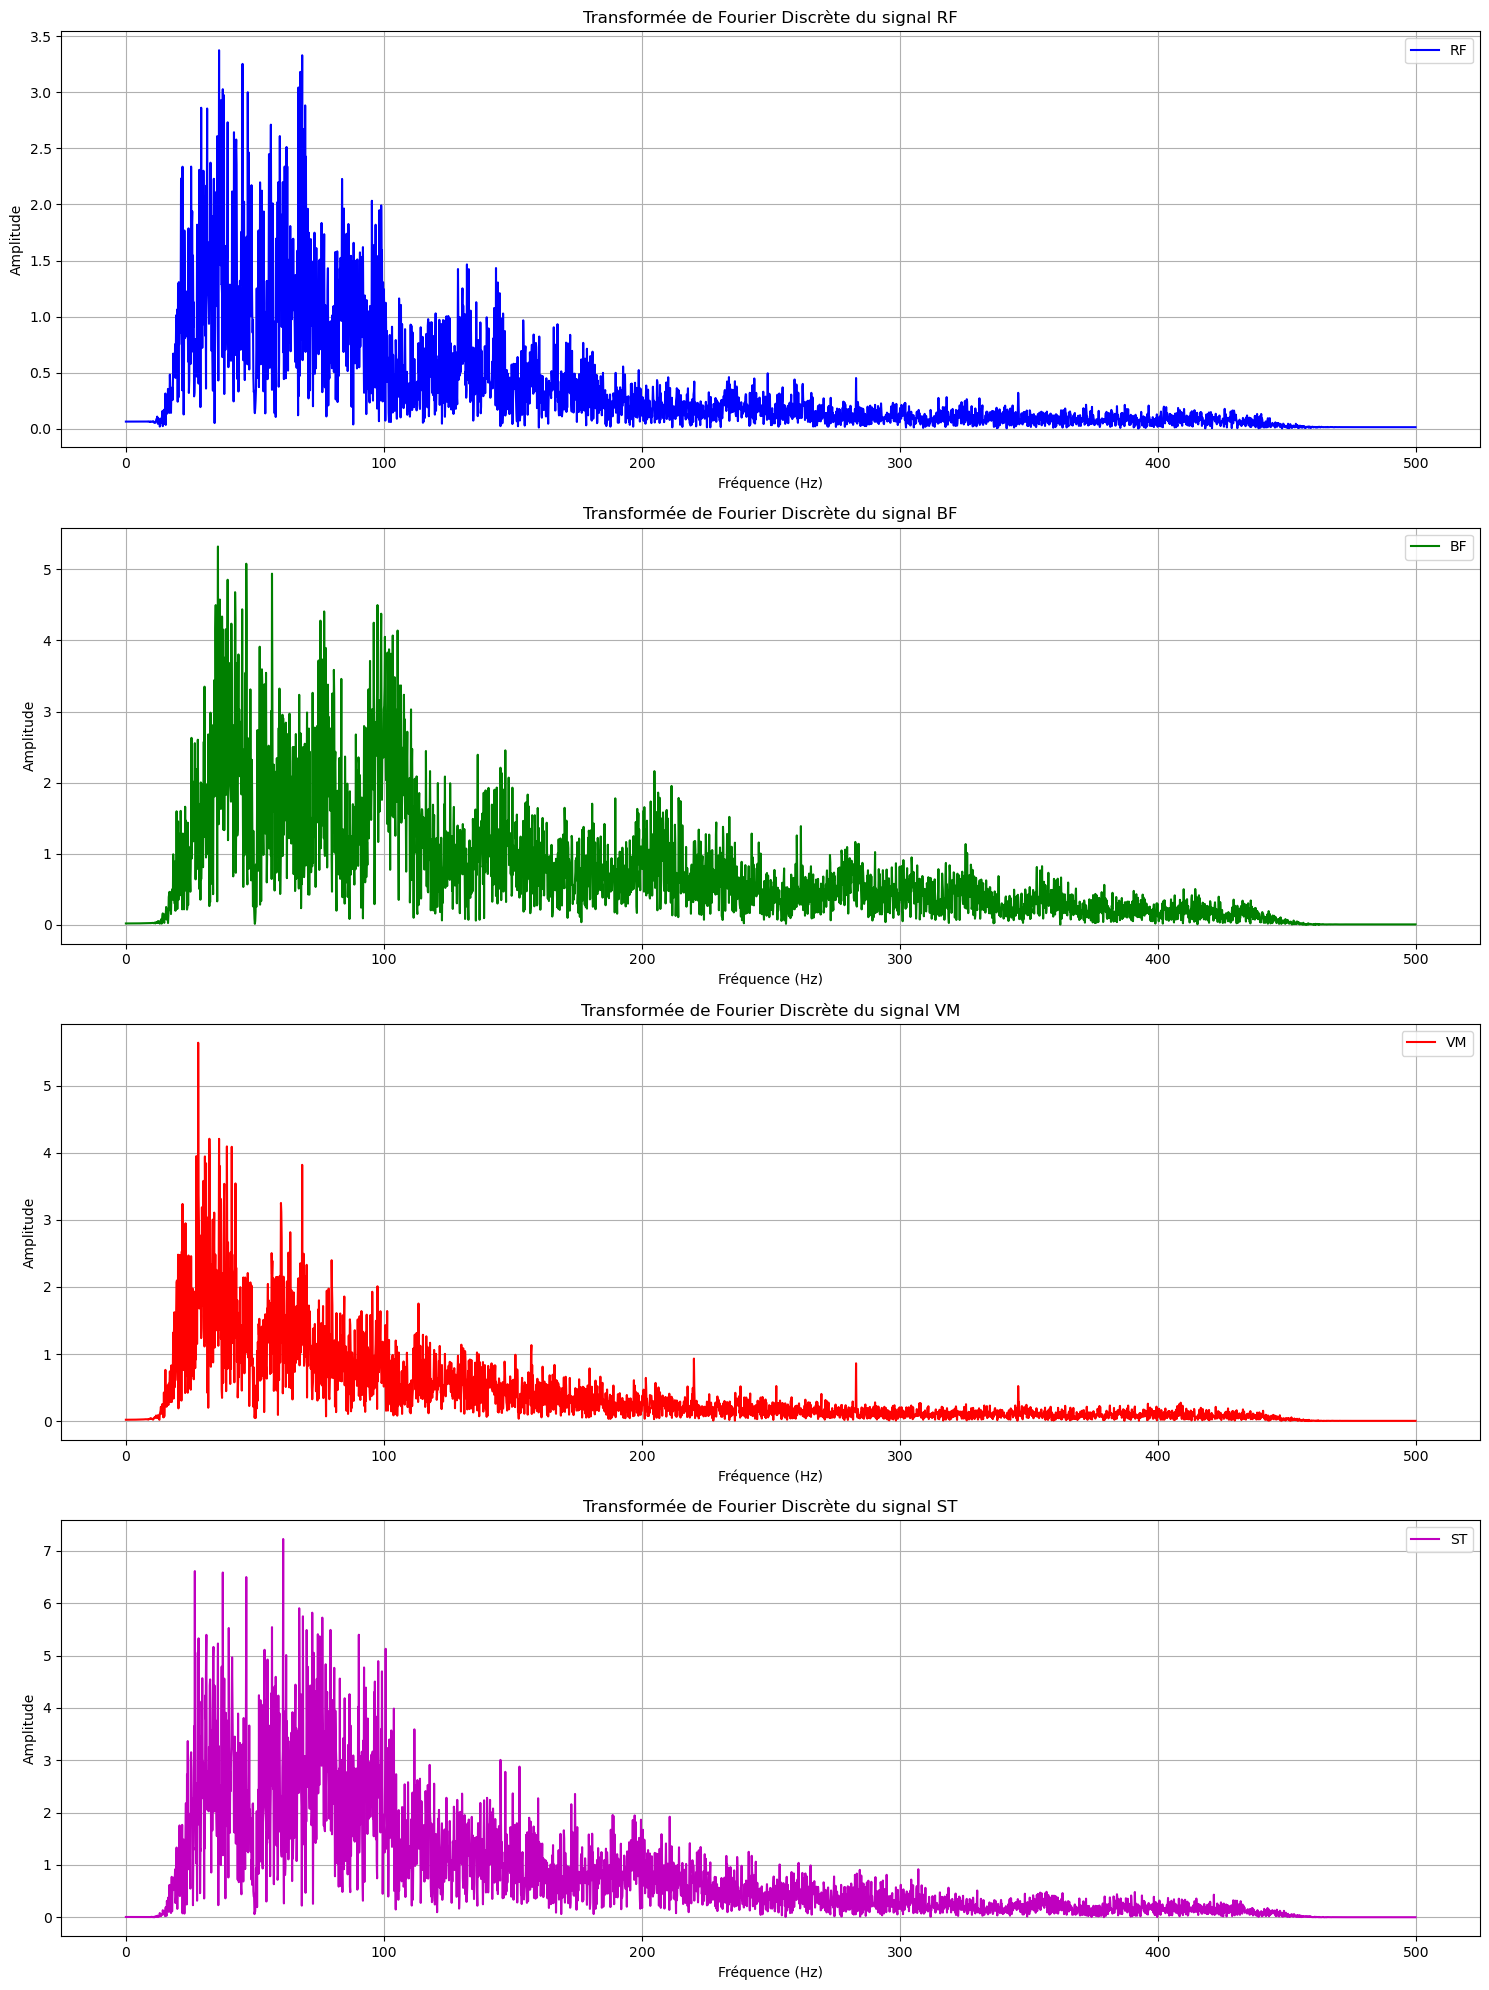

In [11]:
def transform_signal_to_frequency_domain(data, fs=1000):
    T = 1 / fs  # Période d'échantillonnage

    # Calcul de la Transformée de Fourier Discrète
    X = np.fft.fft(data)

    # Calcul des fréquences associées
    n = len(data)  # Nombre d'échantillons
    frequencies = np.fft.fftfreq(n, T)

    # Sélection des fréquences positives pour une meilleure visualisation
    positive_frequencies = frequencies[:n // 2]
    positive_X = X[:n // 2]

    # Calcul de l'amplitude du signal fréquentiel
    amplitude = np.abs(positive_X)

    return positive_frequencies, amplitude

# Transformation des signaux en domaine fréquentiel
frequencies, amplitude_RF = transform_signal_to_frequency_domain(data['RF'])
_, amplitude_BF = transform_signal_to_frequency_domain(data['BF'])
_, amplitude_VM = transform_signal_to_frequency_domain(data['VM'])
_, amplitude_ST = transform_signal_to_frequency_domain(data['ST'])

# Affichage des signaux en domaine fréquentiel sur des graphiques séparés
fig, axs = plt.subplots(4, 1, figsize=(15, 20))

axs[0].plot(frequencies, amplitude_RF, label='RF', color='b')
axs[0].set_xlabel('Fréquence (Hz)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Transformée de Fourier Discrète du signal RF')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(frequencies, amplitude_BF, label='BF', color='g')
axs[1].set_xlabel('Fréquence (Hz)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Transformée de Fourier Discrète du signal BF')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(frequencies, amplitude_VM, label='VM', color='r')
axs[2].set_xlabel('Fréquence (Hz)')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('Transformée de Fourier Discrète du signal VM')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(frequencies, amplitude_ST, label='ST', color='m')
axs[3].set_xlabel('Fréquence (Hz)')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Transformée de Fourier Discrète du signal ST')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


In [12]:
# Convertir les valeurs des pics en entiers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# Initialisation des listes pour stocker les Mean Frequency (MF) par cycle
mf_values_RF = []
mf_values_BF = []
mf_values_VM = []
mf_values_ST = []

# Calcul de la puissance du signal fréquentiel
power_RF = amplitude_RF ** 2
power_BF = amplitude_BF ** 2
power_VM = amplitude_VM ** 2
power_ST = amplitude_ST ** 2

# Calcul de la Mean Frequency (MF) pour chaque muscle
mf_RF = np.sum(frequencies * power_RF) / np.sum(power_RF)
mf_BF = np.sum(frequencies * power_BF) / np.sum(power_BF)
mf_VM = np.sum(frequencies * power_VM) / np.sum(power_VM)
mf_ST = np.sum(frequencies * power_ST) / np.sum(power_ST)

# Affichage des résultats
print("MF pour RF :", mf_RF)
print("MF pour BF :", mf_BF)
print("MF pour VM :", mf_VM)
print("MF pour ST :", mf_ST)


MF pour RF : 73.90366756006144
MF pour BF : 101.7205891952933
MF pour VM : 63.572970683883085
MF pour ST : 84.92617309461653


In [13]:
def calcul_mdf(frequencies, power):
    cumulative_power = np.cumsum(power)
    total_power = cumulative_power[-1]
    half_power = total_power / 2

    # Trouver l'indice où la puissance cumulée dépasse la moitié
    idx = np.where(cumulative_power >= half_power)[0][0]

    # Fréquence correspondante
    return frequencies[idx]

# Calcul des Median Frequencies (MDF)
mdf_RF = calcul_mdf(frequencies, power_RF)
mdf_BF = calcul_mdf(frequencies, power_BF)
mdf_VM = calcul_mdf(frequencies, power_VM)
mdf_ST = calcul_mdf(frequencies, power_ST)

# Affichage des résultats
print("MDF pour RF :", mdf_RF)
print("MDF pour BF :", mdf_BF)
print("MDF pour VM :", mdf_VM)
print("MDF pour ST :", mdf_ST)

MDF pour RF : 62.26524125975152
MDF pour BF : 83.50187806992199
MDF pour VM : 46.66281421554464
MDF pour ST : 73.24472695752672


In [14]:
def calculate_spectral_entropy(power):
    # Normalisation des puissances pour obtenir P(f_k)
    power_sum = np.sum(power)
    if power_sum == 0:
        return 0  # Évite une division par zéro
    P = power / power_sum

    # Suppression des 0 pour éviter log(0)
    P_nonzero = P[P > 0]

    # Entropie spectrale
    entropy = -np.sum(P_nonzero * np.log(P_nonzero))
    return entropy

# Calcul de l'entropie spectrale pour chaque muscle
se_RF = calculate_spectral_entropy(power_RF)
se_BF = calculate_spectral_entropy(power_BF)
se_VM = calculate_spectral_entropy(power_VM)
se_ST = calculate_spectral_entropy(power_ST)

# Affichage des résultats
print("Spectral Entropy pour RF :", se_RF)
print("Spectral Entropy pour BF :", se_BF)
print("Spectral Entropy pour VM :", se_VM)
print("Spectral Entropy pour ST :", se_ST)

Spectral Entropy pour RF : 6.440423251824892
Spectral Entropy pour BF : 6.839215561448673
Spectral Entropy pour VM : 6.288452984014735
Spectral Entropy pour ST : 6.627788823048037
